# **Environmental predictors of bird species richness across the United States: a route-based spatial analysis**
A route-based analysis of bird species richness across the contiguous United States, using BBS routes as the observational units and environmental predictors summarized along each route.


## Research objectives

Quantify spatial variation in bird species richness across the contiguous United States using BBS routes.

Assess how NDVI and elevation predict species richness at the route level.

Evaluate spatial autocorrelation in species richness and model residuals.

## 1. Building the dataset - Initial data exploration and visualisation

In [12]:
# Libraries
import geopandas as gpd
import pandas as pd
import httpx
import requests
import matplotlib.pyplot as plt
import io

### Study area

First load the data about the US states:

In [123]:
states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip"
r = httpx.get(states_url, verify=False, timeout=None)
us_states = gpd.read_file(r.content, engine="pyogrio")
exclude = ['AK', 'HI', 'PR', 'VI', 'MP', 'GU', 'AS'] # States outside the area of interest
states = us_states.query("STUSPS not in @exclude") # Accesing the exclude variable outside the query() string
us_boundary = states.dissolve()
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


### BBS data

In [15]:
url = "https://raw.githubusercontent.com/matejtvar/SDS_assignement/main/bbs_routes_SR_2018.gpkg"
r = requests.get(url)
bbs = gpd.read_file(io.BytesIO(r.content), engine = "fiona")
bbs = bbs.loc[bbs["CountryNum"] == 840] # Select only US transects
bbs = bbs.loc[bbs["StateNum"] != 3] # Select every state except Alaska
bbs.head()

,RTENO,RouteName,StateNum,Route,CountryNum,species_richness,geometry
0,84002001,ST FLORIAN,2,001,840,63,POINT (-87.60414 34.86869)
1,84002004,TRADE,2,004,840,51,POINT (-87.05924 34.02979)
2,84002007,SWAIM,2,007,840,63,POINT (-86.20304 34.86804)
3,84002008,PINE GROVE,2,008,840,66,POINT (-85.71104 34.02781)
4,84002010,MILLERVILLE,2,010,840,59,POINT (-85.92584 33.19135)


In [17]:
routes_url = "https://earthworks.stanford.edu/download/file/stanford-vy474dv5024-geojson.json"

# Defining headers to mimic a browser (avoids 403 Forbidden errors)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

r = requests.get(routes_url, headers=headers)

if r.status_code == 200:
    routes = gpd.read_file(io.BytesIO(r.content), engine="pyogrio")
    print(routes.info())
else:
    print(f"Failed. Status: {response.status_code}")

Skipping field bbox: unsupported OGR type: 3


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3731 entries, 0 to 3730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          3731 non-null   object  
 1   fnode_      3731 non-null   int32   
 2   tnode_      3731 non-null   int32   
 3   lpoly_      3731 non-null   int32   
 4   rpoly_      3731 non-null   int32   
 5   length      3731 non-null   float64 
 6   bbsrtsl020  3731 non-null   int32   
 7   arc_length  3731 non-null   float64 
 8   rteno       3731 non-null   int32   
 9   rtename     3730 non-null   object  
 10  rteleng     3731 non-null   float64 
 11  geometry    3731 non-null   geometry
dtypes: float64(3), geometry(1), int32(6), object(2)
memory usage: 262.5+ KB
None


In [124]:
routes = routes.to_crs(epsg=5070)
routes['calc_length_km'] = routes.geometry.length / 1000

# Filter out fragments and over-long routes
mask = (routes['calc_length_km'] >= 35) & (routes['calc_length_km'] <= 45)
routes_filtered = routes[mask].copy()

# Remove duplicate 'rteno' rows 
routes_final = routes_filtered.drop_duplicates(subset=['rteno'])

print(f"Original row count: {len(routes)}")
print(f"Cleaned row count (35-48km): {len(routes_final)}")
print(f"Average length: {routes_final['calc_length_km'].mean():.2f} km")

Original row count: 2661
Cleaned row count (35-48km): 2661
Average length: 40.22 km


In [125]:
routes = routes_final[['rteno', 'rteleng', 'geometry']]
bbs = bbs.to_crs(epsg=5070)
routes.crs.equals(bbs.crs)


True

In [23]:
# Add a small buffer (400 m) to points to account for GPS inaccuracy
bbs_buffered = bbs.copy()
bbs_buffered['geometry'] = bbs_buffered.buffer(400)

# Spatial join of bbs points data with the routes geometries
joined_data = gpd.sjoin(routes, bbs_buffered, how='inner', predicate='intersects')

# 4. Check for duplicates
# Since one point might touch two route segments, or vice versa
print(f"Matched {len(joined_data)} route-point pairs.")

# 5. Filter check
# See which routes lost their points
print(f"Routes in subset: {len(routes)}")
print(f"Routes with data: {len(joined_data['rteno'].unique())}")

Matched 1668 route-point pairs.
Routes in subset: 2661
Routes with data: 1659


In [127]:
 # Dropping possible duplicates and reorganising the table
bbs_routes = joined_data.drop_duplicates(subset=['rteno'])
bbs_routes = bbs_routes.drop(columns = ["RTENO", "CountryNum", "RouteName", "index_right", "Route"])
new_order = ['rteno', 'rteleng', 'StateNum', 'species_richness', "geometry"]
bbs_routes = bbs_routes[new_order]

# Calculate the midpoint (50% along the line) for spatial weights
bbs_routes["spatial_ref_point"] = bbs_routes.geometry.interpolate(0.5, normalized=True)

# Creating 5 km buffer
bbs_routes["buff_5000"] = bbs_routes.buffer(5000)

bbs_routes.head()

,rteno,rteleng,StateNum,species_richness,geometry,spatial_ref_point,buff_5000
0,2072,39658.1,2,63,"MULTILINESTRING ((782641.086 1356740.039, 7827...",POINT (799058.572 1358112.819),"POLYGON ((781444.31 1351282.844, 781080.681 13..."
2,2204,44896.5,2,54,"MULTILINESTRING ((924730.744 1363310.348, 9247...",POINT (920348.379 1362929.766),"POLYGON ((909651.978 1349408.223, 909642.34 13..."
3,2073,41350.3,2,65,"MULTILINESTRING ((885664.635 1341263.847, 8856...",POINT (896739.468 1353510.85),"POLYGON ((881582.169 1344150.743, 881920.966 1..."
4,2071,37331.3,2,61,"MULTILINESTRING ((763430.539 1332485.496, 7634...",POINT (776778.912 1331128.439),"POLYGON ((765146.155 1325367.953, 763912.471 1..."
5,2007,44022.0,2,63,"MULTILINESTRING ((868470.938 1344038.894, 8689...",POINT (879587.923 1341112.567),"POLYGON ((867783.618 1339092.383, 867517.304 1..."


### NDVI raster

For the NDVI data I decided to use Vegetation Index (1 month - Terra/MODIS) from NEO (Nasa Earth Observations) - https://neo.gsfc.nasa.gov/view.php?datasetId=MOD_NDVI_M&date=2018-06-01

Normalized Difference Vegetation Index (NDVI) describes the health of vegetation within pixels of a raster image by measuring the amount of near-infrared (NIR) light being reflected by vegetation. Healthy vegetation reflects more NIR and less red relative to unhealthy vegetation or inorganic matter of the same visible color (such as turf fields), making it convenient for assessing the relative health of vegetation in a raster image compared to its surroundings.

NDVI is calculated for each pixel with the following calculation:

$\Large NDVI = \frac{(NIR - Red)}{(NIR + Red)}$

This formula generates a value between -1 and +1. Low reflectance in the red channel and high reflectance in the NIR channel will yield a high NDVI value (healthy vegetation), while the inverse will result in a low NDVI value (unhealthy vegetation). Negative values typically represent non-vegetation such as water or rock.


In [28]:
import datashader as ds
import geopandas as gpd
import rioxarray
import osmnx as ox
import xvec

In [83]:
url = "https://raw.githubusercontent.com/matejtvar/SDS_assignement/main/MOD_NDVI_M_2018-06-01_rgb_3600x1800.TIFF"

# Download content as bytes
r = requests.get(url)

if r.status_code == 200:
    # Read from memory buffer
    ndvi = rioxarray.open_rasterio(io.BytesIO(r.content))
    print("Successfully loaded NDVI raster.")
else:
    print(f"Failed to download. Status code: {r.status_code}")

Successfully loaded NDVI raster.


In [84]:
ndvi.head()

<xarray.DataArray (band: 1, y: 5, x: 5)> Size: 25B
[25 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B -179.9 -179.8 -179.8 -179.6 -179.5
  * y            (y) float64 40B 89.95 89.85 89.75 89.65 89.55
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [85]:
ndvi_us = ndvi.rio.clip(us_boundary.to_crs(ndvi.rio.crs).geometry)
ndvi_us

<xarray.DataArray (band: 1, y: 248, x: 577)> Size: 143kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 248, 577), dtype=uint8)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

In [32]:
ndvi_us = ndvi_us.drop_vars("band").squeeze() # Getting rid of redundant dimension
ndvi_us

<xarray.DataArray (y: 248, x: 577)> Size: 143kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(248, 577), dtype=uint8)
Coordinates:
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

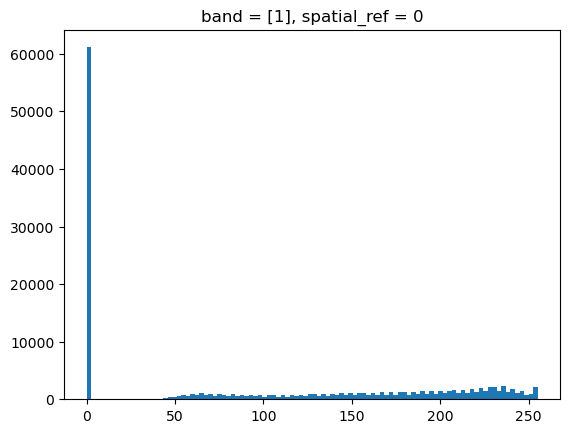

In [86]:
_ = ndvi_us.plot.hist(bins=100)

There are a lot of zeros, so I need to filter them out.

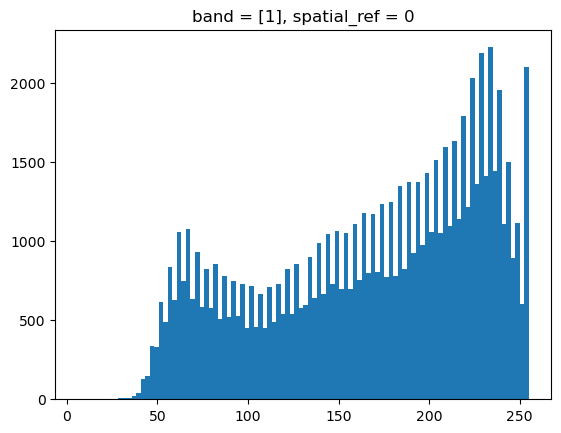

In [87]:
ndvi_us = ndvi_us.where(ndvi_us>0)
_ = ndvi_us.where(ndvi_us>0).plot.hist(bins=100)

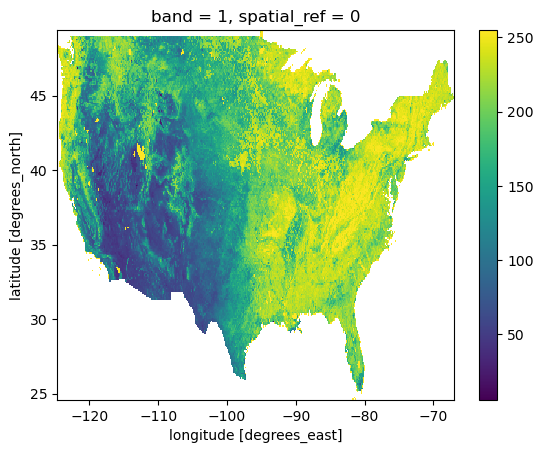

In [88]:
_ = ndvi_us.plot()

Now it is time to extract NDVI values for each transect using buffer of 1 km from routes geometry.

In [89]:
# Check the pixel size (width and height)
pixel_width, pixel_height = ndvi_us.rio.resolution()
print(f"Pixel resolution: {pixel_width} x {pixel_height}")

# Check the CRS to see if it's in degrees (4326) or meters
print(f"Raster CRS: {ndvi_us.rio.crs}")

Pixel resolution: 0.09999999999999999 x -0.09999999999999998
Raster CRS: EPSG:4326


In [95]:
ndvi_us = ndvi_us.rio.reproject("EPSG:5070")
print(f"New Resolution in meters: {ndvi_us.rio.transform()[0]}")

New Resolution in meters: 9007.395170646003


In [96]:
ndvi_extraction = bbs_routes.set_geometry("buff_5000").to_crs(ndvi_us.rio.crs)

zonal_stats = ndvi_us.drop_vars("spatial_ref").xvec.zonal_stats(
    geometry=ndvi_extraction.buff_5000,
    x_coords="x",
    y_coords="y",
    stats=["mean", "std"],
)
zonal_stats

<xarray.DataArray (geometry: 1659, zonal_statistics: 2, band: 1)> Size: 13kB
array([[[224.6      ],
        [ 11.359578 ]],

       [[238.5      ],
        [ 11.729592 ]],

       [[252.       ],
        [  2.828427 ]],

       ...,

       [[129.75     ],
        [  9.0932665]],

       [[164.5      ],
        [ 30.560051 ]],

       [[131.57143  ],
        [ 17.327576 ]]], shape=(1659, 2, 1), dtype=float32)
Coordinates:
  * band              (band) int64 8B 1
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
  * geometry          (geometry) geometry 13kB POLYGON ((781444.3095840941 13...
    index             (geometry) int64 13kB 0 2 3 4 5 ... 3726 3728 3729 3730
Indexes:
    geometry  GeometryIndex (crs=EPSG:5070)
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0.0

In [97]:
ndvi_data = zonal_stats.xvec.to_geodataframe(name="NDVI")
ndvi_data.head()

,,geometry,index,NDVI
zonal_statistics,band,,,
mean,1,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,224.600006
std,1,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,11.359578
mean,1,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,238.500000
std,1,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,11.729592
mean,1,"POLYGON ((881582.169 1344150.743, 881920.966 1...",3,252.000000


In [ ]:
ndvi_data.loc[("mean")].explore("NDVI", cmap="cividis_r", tiles="CartoDB Positron")

In [99]:
# Returns the count of NaNs for every column in the dataframe
print(ndvi_data.isna().sum())

geometry    0
index       0
NDVI        6
dtype: int64


In [100]:
# Drop rows where the NDVI value is missing
ndvi_data_final = ndvi_data.dropna(subset=['NDVI'])

# Check how many rows were removed
print(f"Rows before: {len(ndvi_data)}")
print(f"Rows after: {len(ndvi_data_final)}")

Rows before: 3318
Rows after: 3312


In [101]:
ndvi_data_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 3312 entries, ('mean', np.int64(1)) to ('std', np.int64(1))
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  3312 non-null   geometry
 1   index     3312 non-null   int64   
 2   NDVI      3312 non-null   float32 
dtypes: float32(1), geometry(1), int64(1)
memory usage: 71.5+ KB


In [103]:
# This creates a table with index as rows and mean/std/min/max as columns
ndvi_stats = ndvi_data_final.reset_index().pivot(
    index='index', 
    columns='zonal_statistics', 
    values='NDVI'
)

# Add the 'ndvi_' prefix to the new columns
ndvi_stats.columns = ['ndvi_' + col for col in ndvi_stats.columns]

# Get the unique geometries for each index
geometries = ndvi_data_final[['index', 'geometry']].drop_duplicates('index').set_index('index')

# Join them together
ndvi_wide = geometries.join(ndvi_stats).reset_index()

ndvi_wide.head()

,index,geometry,ndvi_mean,ndvi_std
0,0,"POLYGON ((781444.31 1351282.844, 781080.681 13...",224.600006,11.359578
1,2,"POLYGON ((909651.978 1349408.223, 909642.34 13...",238.500000,11.729592
2,3,"POLYGON ((881582.169 1344150.743, 881920.966 1...",252.000000,2.828427
3,4,"POLYGON ((765146.155 1325367.953, 763912.471 1...",200.750000,3.418699
4,5,"POLYGON ((867783.618 1339092.383, 867517.304 1...",238.833328,18.261223


In [105]:
ndvi_wide.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   index      1656 non-null   int64   
 1   geometry   1656 non-null   geometry
 2   ndvi_mean  1656 non-null   float32 
 3   ndvi_std   1656 non-null   float32 
dtypes: float32(2), geometry(1), int64(1)
memory usage: 38.9 KB


In [107]:
bbs_routes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1659 entries, 0 to 3730
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rteno              1659 non-null   int32   
 1   rteleng            1659 non-null   float64 
 2   StateNum           1659 non-null   int64   
 3   species_richness   1659 non-null   int64   
 4   geometry           1659 non-null   geometry
 5   spatial_ref_point  1659 non-null   geometry
 6   buff_5000          1659 non-null   geometry
dtypes: float64(1), geometry(3), int32(1), int64(2)
memory usage: 97.2 KB


In [109]:
ndvi_to_join = ndvi_wide[['ndvi_mean', 'ndvi_std', 'geometry']]

buffer = bbs_routes.set_geometry('buff_5000')

# Perform the Spatial Join
# 'predicate=inner' ensures the polygons must overlap/be the same
# 'how=inner' keeps only rows that exist in both sets
bbs_ndvi = gpd.sjoin(
    buffer, 
    ndvi_to_join, 
    how='inner', 
    predicate='intersects'
)

# sjoin adds an 'index_right' column we usually don't need
if 'index_right' in bbs_ndvi.columns:
    bbs_ndvi = bbs_ndvi.drop(columns='index_right')

bbs_ndvi = bbs_ndvi.drop_duplicates(subset=['rteno'])

bbs_ndvi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1659 entries, 0 to 3730
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   rteno              1659 non-null   int32   
 1   rteleng            1659 non-null   float64 
 2   StateNum           1659 non-null   int64   
 3   species_richness   1659 non-null   int64   
 4   geometry           1659 non-null   geometry
 5   spatial_ref_point  1659 non-null   geometry
 6   buff_5000          1659 non-null   geometry
 7   ndvi_mean          1659 non-null   float32 
 8   ndvi_std           1659 non-null   float32 
dtypes: float32(2), float64(1), geometry(3), int32(1), int64(2)
memory usage: 110.2 KB


In [110]:
bbs_ndvi.head()

,rteno,rteleng,StateNum,species_richness,geometry,spatial_ref_point,buff_5000,ndvi_mean,ndvi_std
0,2072,39658.1,2,63,"MULTILINESTRING ((782641.086 1356740.039, 7827...",POINT (799058.572 1358112.819),"POLYGON ((781444.31 1351282.844, 781080.681 13...",224.600006,11.359578
2,2204,44896.5,2,54,"MULTILINESTRING ((924730.744 1363310.348, 9247...",POINT (920348.379 1362929.766),"POLYGON ((909651.978 1349408.223, 909642.34 13...",238.500000,11.729592
3,2073,41350.3,2,65,"MULTILINESTRING ((885664.635 1341263.847, 8856...",POINT (896739.468 1353510.85),"POLYGON ((881582.169 1344150.743, 881920.966 1...",238.833328,18.261223
4,2071,37331.3,2,61,"MULTILINESTRING ((763430.539 1332485.496, 7634...",POINT (776778.912 1331128.439),"POLYGON ((765146.155 1325367.953, 763912.471 1...",200.750000,3.418699
5,2007,44022.0,2,63,"MULTILINESTRING ((868470.938 1344038.894, 8689...",POINT (879587.923 1341112.567),"POLYGON ((867783.618 1339092.383, 867517.304 1...",238.833328,18.261223


### Elevation raster

In [111]:
url = "https://raw.githubusercontent.com/matejtvar/SDS_assignement/main/stanford-zz186ss2071-geotiff.tif"

# Here is the original path to the file: https://neo.gsfc.nasa.gov/servlet/RenderData?si=1989141&cs=rgb&format=TIFF&width=3600&height=1800

# Download content as bytes
r = requests.get(url)

if r.status_code == 200:
    # Read from memory buffer
    elevation = rioxarray.open_rasterio(io.BytesIO(r.content))
    print("Successfully loaded elevation raster.")
else:
    print(f"Failed to download. Status code: {r.status_code}")

Successfully loaded elevation raster.


In [112]:
elevation_us = elevation.rio.clip(us_boundary.to_crs(elevation.rio.crs).geometry)
elevation_us.sel(band=1)

<xarray.DataArray (y: 1497, x: 3483)> Size: 5MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1497, 3483), dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 28kB -124.7 -124.7 -124.7 ... -67.02 -67.0 -66.98
  * y            (y) float64 12kB 49.37 49.35 49.33 49.32 ... 24.59 24.57 24.55
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

In [ ]:
_ = elevation_us.plot()

In [ ]:
_ = elevation_us.plot.hist(bins=100)

In [115]:
elevation_us = elevation_us.where(elevation_us>0)

In [ ]:
_ = elevation_us.plot()

In [117]:
# Check the pixel size (width and height)
pixel_width, pixel_height = elevation_us.rio.resolution()
print(f"Pixel resolution: {pixel_width} x {pixel_height}")

# Check the CRS to see if it's in degrees (4326) or meters
print(f"Raster CRS: {elevation_us.rio.crs}")

Pixel resolution: 0.016579539707050228 x -0.01658709807301497
Raster CRS: EPSG:4326


In [118]:
# 2. Reproject to Meters (EPSG:5070)
# This uses 'bilinear' or 'cubic' resampling to keep elevation smooth
elevation_us = elevation_us.rio.reproject("EPSG:5070")

# 3. Check the new resolution
print(f"New Resolution in meters: {elevation_us.rio.transform()[0]}")

New Resolution in meters: 1494.0753014683846


In [119]:
elevation_extraction = bbs_ndvi.set_geometry("buff_5000").to_crs(elevation_us.rio.crs)

ele_stats = ndvi_us.drop_vars("spatial_ref").xvec.zonal_stats(
    geometry=elevation_extraction.buff_5000,
    x_coords="x",
    y_coords="y",
    stats=["mean", "std"],
)
ele_stats

<xarray.DataArray (geometry: 1659, zonal_statistics: 2, band: 1)> Size: 13kB
array([[[224.6      ],
        [ 11.359578 ]],

       [[238.5      ],
        [ 11.729592 ]],

       [[252.       ],
        [  2.828427 ]],

       ...,

       [[129.75     ],
        [  9.0932665]],

       [[164.5      ],
        [ 30.560051 ]],

       [[131.57143  ],
        [ 17.327576 ]]], shape=(1659, 2, 1), dtype=float32)
Coordinates:
  * band              (band) int64 8B 1
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
  * geometry          (geometry) geometry 13kB POLYGON ((781444.3095840941 13...
    index             (geometry) int64 13kB 0 2 3 4 5 ... 3726 3728 3729 3730
Indexes:
    geometry  GeometryIndex (crs=EPSG:5070)
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0.0

In [120]:
elevation_data = ele_stats.xvec.to_geodataframe(name="elevation")
elevation_data.head()

,,geometry,index,elevation
zonal_statistics,band,,,
mean,1,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,224.600006
std,1,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,11.359578
mean,1,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,238.500000
std,1,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,11.729592
mean,1,"POLYGON ((881582.169 1344150.743, 881920.966 1...",3,252.000000


In [ ]:
# elevation_data.loc[("mean")].explore("elevation", cmap="cividis_r", tiles="CartoDB Positron")

## 2. Spatial autocorrelation of species richness - Exploration of a degree of randomness of data

In [ ]:
m = bbs_ndvi.set_geometry('spatial_ref_point').explore(
    column='species_richness',  
    cmap='viridis',              
    tooltip=[
        'rteno', 
        'species_richness', 
        'ndvi_mean', 
        'ndvi_std'
    ],                           
    popup=True,                 
    tiles="CartoDB positron",
    marker_kwds=dict(radius=6, fill=True) # Adjust point size
)

# m